# Analysis of real results

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

def load_and_expand_telemetry(folder_path):
    all_data = []

    # Walk through all subfolders and files
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            
            # Only process files without an extension
            if not os.path.splitext(file)[1]:  
                with open(file_path, "r", encoding="utf-8") as f:
                    for line in f:
                        try:
                            json_obj = json.loads(line.strip())  # Load each line as a JSON object
                            
                            if "telemetry" in json_obj and isinstance(json_obj["telemetry"], dict):
                                # Expand telemetry fields
                                telemetry_data = json_obj.pop("telemetry")  # Remove telemetry field
                                expanded_record = {**json_obj, **telemetry_data}  # Merge dictionaries
                            else:
                                expanded_record = json_obj  # If no telemetry field, keep original

                            all_data.append(expanded_record)
                        except json.JSONDecodeError as e:
                            print(f"Skipping invalid JSON in {file_path}: {e}")

    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    return df

# Example usage
folder_path = r"C:\Users\NikolaiKummer\Documents\GIT\remote-data-collection\data\27cbf2b6-ab2f-49d6-9f05-fd938a9792b3"
df = load_and_expand_telemetry(folder_path)


In [2]:
keep_columns = ['deviceId','enqueuedTime', 'volt', 'bat', 'timestamp', 'last_state']
df = df[keep_columns]

In [ ]:
start_date = '2024-10-05T01:27:16.842Z'
end_date = '2024-10-14T19:41:21.170Z'

def fill_missing_timestamps(df, column='timestamp'):
    """
    Fills missing values in a timestamp column with the average of the previous and next timestamp.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing a timestamp column.
    column (str): Name of the timestamp column. Default is 'timestamp'.
    
    Returns:
    pd.DataFrame: DataFrame with missing timestamps filled.
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    df[column] = pd.to_datetime(df[column])  # Ensure timestamps are in datetime format

    # Identify missing values
    missing_idx = df[column].isna()
    df[column] = df[column].astype('int64')
    # Fill missing values with the midpoint of the previous and next timestamps
    df.loc[missing_idx, column] = (df[column].shift(1) + df[column].shift(-1)) / 2
    df[column] = pd.to_datetime(df[column])  # Convert back to datetime format
    return df


df['enqueuedTime'] = pd.to_datetime(df['enqueuedTime'])
df = df[(df['enqueuedTime'] >= start_date) & (df['enqueuedTime'] <= end_date)]

# Clean up timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.loc[df['timestamp'] < pd.Timestamp('2024-01-01'), 'timestamp'] = pd.NaT
df = fill_missing_timestamps(df)

In [25]:
df

,deviceId,enqueuedTime,volt,bat,timestamp,last_state
3204,eco-tracker-01,2024-10-05 01:27:16.842000+00:00,3.9500,70.11719,2024-10-05 00:23:45,16980.0
3205,eco-tracker-01,2024-10-05 01:27:18.217000+00:00,3.9413,68.80469,2024-10-05 01:26:31,16511.0
3206,eco-tracker-01,2024-10-05 03:13:19.231000+00:00,3.9225,66.43359,2024-10-05 02:40:31,16045.0
3207,eco-tracker-01,2024-10-05 03:13:19.466000+00:00,3.9188,66.14453,2024-10-05 03:13:03,16051.0
3208,eco-tracker-01,2024-10-05 04:34:29.212000+00:00,4.0462,67.15625,2024-10-05 03:53:36,16260.0
...,...,...,...,...,...,...
3515,eco-tracker-01,2024-10-13 18:51:40.261000+00:00,3.3438,0.06641,2024-10-13 18:51:23,125.0
3516,eco-tracker-01,2024-10-13 19:24:32.253000+00:00,3.3050,0.03906,2024-10-13 19:24:14,130.0
3517,eco-tracker-01,2024-10-13 19:57:50.212000+00:00,3.2575,0.00000,2024-10-13 19:57:06,135.0
3518,eco-tracker-01,2024-10-13 20:31:01.200000+00:00,3.1925,0.00000,2024-10-13 20:30:25,140.0


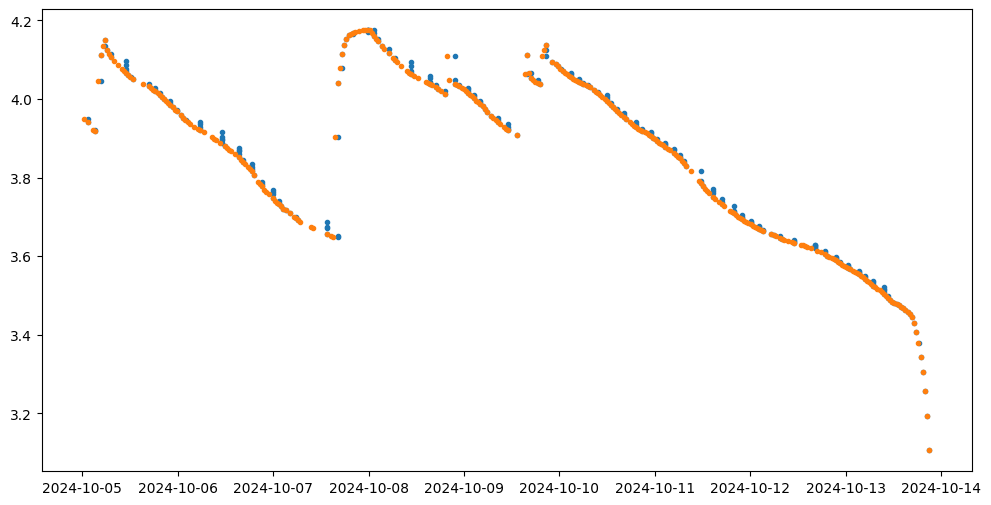

In [26]:
fig = plt.figure(figsize=(12, 6))

plt.plot(df['enqueuedTime'], df['volt'], '.')
plt.plot(df['timestamp'], df['volt'], '.')

In [ ]:
# Create a difference in timestamp column
dft = df.copy()

,deviceId,enqueuedTime,volt,bat,timestamp,last_state
3204,eco-tracker-01,2024-10-05 01:27:16.842000+00:00,3.9500,70.11719,2024-10-05 00:23:45+00:00,16980.0
3205,eco-tracker-01,2024-10-05 01:27:18.217000+00:00,3.9413,68.80469,2024-10-05 01:26:31+00:00,16511.0
3206,eco-tracker-01,2024-10-05 03:13:19.231000+00:00,3.9225,66.43359,2024-10-05 02:40:31+00:00,16045.0
3207,eco-tracker-01,2024-10-05 03:13:19.466000+00:00,3.9188,66.14453,2024-10-05 03:13:03+00:00,16051.0
3208,eco-tracker-01,2024-10-05 04:34:29.212000+00:00,4.0462,67.15625,NaT,16260.0
...,...,...,...,...,...,...
3515,eco-tracker-01,2024-10-13 18:51:40.261000+00:00,3.3438,0.06641,2024-10-13 18:51:23+00:00,125.0
3516,eco-tracker-01,2024-10-13 19:24:32.253000+00:00,3.3050,0.03906,2024-10-13 19:24:14+00:00,130.0
3517,eco-tracker-01,2024-10-13 19:57:50.212000+00:00,3.2575,0.00000,2024-10-13 19:57:06+00:00,135.0
3518,eco-tracker-01,2024-10-13 20:31:01.200000+00:00,3.1925,0.00000,2024-10-13 20:30:25+00:00,140.0
